In [ ]:
import tensorflow as tf

img_size = (128,128)
batch_size = 32

# I wrote a seperate script for splitting dataset due to some bugs I faced instead of using libraries

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Dataset_Split/train",
    image_size = img_size,
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Dataset_Split/val",
    image_size = img_size,
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Dataset_Split/test",
    image_size = img_size,
    batch_size=batch_size
)

Found 3500 files belonging to 2 classes.
Found 750 files belonging to 2 classes.
Found 750 files belonging to 2 classes.


In [2]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
from tensorflow.keras import layers, models

model = models.Sequential(
    [
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)

d:\Programs\Compilers\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10
)

# Overfitting with 0.9992 accuracy but let's just see the reports

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.6934 - loss: 0.5741 - val_accuracy: 0.9013 - val_loss: 0.2838
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.8990 - loss: 0.2628 - val_accuracy: 0.9400 - val_loss: 0.1797
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9497 - loss: 0.1524 - val_accuracy: 0.9627 - val_loss: 0.1305
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.9767 - loss: 0.0816 - val_accuracy: 0.9493 - val_loss: 0.1298
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.9850 - loss: 0.0530 - val_accuracy: 0.9720 - val_loss: 0.0999
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.9878 - loss: 0.0389 - val_accuracy: 0.9680 - val_loss: 0.1280
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9891 - loss: 0.0292 - val_accuracy: 0.9827 - val_loss: 0.1031
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9935 - loss: 0

In [ ]:
#import numpy as np

# Get true labels and images from val_ds, val_ds is the one I created in the beginning for split
y_true = []
images = []

for img_batch, label_batch in val_ds:
    images.append(img_batch)
    y_true.append(label_batch)

# Stack them
images = tf.concat(images, axis=0)
y_true = tf.concat(y_true, axis=0).numpy()


In [ ]:
# Get predictions from the model will return probabilty i.e between 0 and 1
y_pred_probs = model.predict(images)

# Convert probabilities to class labels (0 or 1) if > 0.5 then class Tumor else class Healthy
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


              precision    recall  f1-score   support

     Healthy       0.97      0.98      0.98       300
       Tumor       0.99      0.98      0.98       450

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



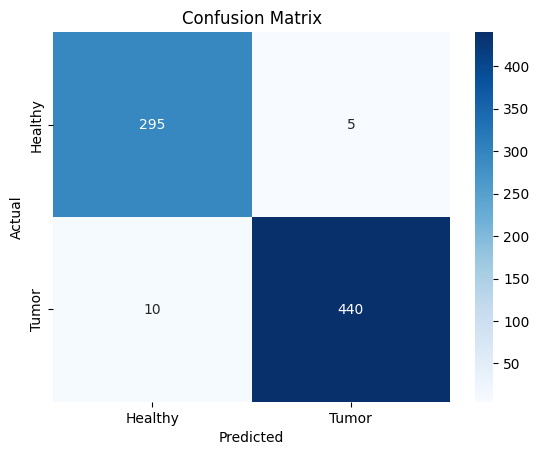

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=["Healthy", "Tumor"]))

cm = confusion_matrix(y_true, y_pred)

# Plotting
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Healthy", "Tumor"], yticklabels=["Healthy", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save in modern .keras format instead of old .h5

model.save('models/cnn-model.keras')

In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("models/cnn-model.keras")

img_path = "test_img3.png"  # your test image
img = image.load_img(img_path, target_size=img_size, color_mode='rgb')  # or 'grayscale' if used

# Convert to array and normalize
img_array = image.img_to_array(img)
img_array = img_array / 255.0 
img_array = np.expand_dims(img_array, axis=0)


In [48]:
from tensorflow.keras.preprocessing import image

def predict(img_path):
    img_path = img_path  # your test image
    img = image.load_img(img_path, target_size=img_size, color_mode='rgb')  # or 'grayscale' if used

    # Convert to array and normalize
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    print("Prediction (raw):", pred)

    classes = ["Tumor", "Healthy"]
    final_label = ''
    pred = model.predict(img_array)[0][0]  # this gives a value like 0.87
    if pred < 0.5:
        final_label = 'Healthy'
        print("Predicted: Healthy")
    else:
        final_label = 'Tumor'
        print("Predicted: Tumor")

    plt.imshow(img)
    plt.title("Predicted: " + final_label)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction (raw): [[1.0144156e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: Healthy


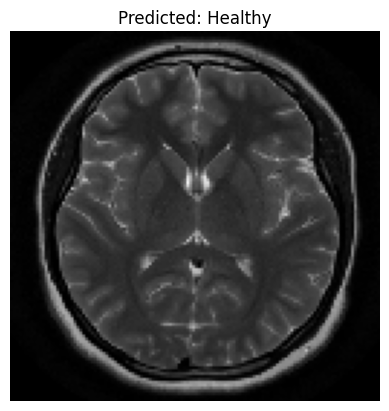

In [52]:
predict('custom_test_images/test_img3.png')